# But : Créer un masque sans végétation avec une image infrarouge Pléiade.

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [3]:
!pip install pyarrow
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 23.6 MB/s eta 0:00:0000:0100:01


In [ ]:
! sudo apt-get update
! sudo apt-get install ffmpeg libsm6 libxext6 -y
! sudo apt-get install libgl1


In [3]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from image_utils import *
import mappings as mapps

In [ ]:
import cv2

In [4]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date
import os

In [5]:
update_storage_access()

In [6]:
environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

#2022
#guyane 2022
path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

#martinique 2022
path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]
          
#guadeloupe 2022
path_s3_pleiades_data_2022_guadeloupe = environment["sources"]["PLEIADES"][2022]["guadeloupe"]
path_local_pleiades_data_2022_guadeloupe = environment["local-path"]["PLEIADES"][2022]["guadeloupe"]

#mayotte 2022
path_s3_pleiades_data_2022_mayotte = environment["sources"]["PLEIADES"][2022]["mayotte"]
path_local_pleiades_data_2022_mayotte = environment["local-path"]["PLEIADES"][2022]["mayotte"]

#2020
#mayotte 2020
path_s3_pleiades_data_2020_mayotte = environment["sources"]["PLEIADES"][2020]["mayotte"]
path_local_pleiades_data_2020_mayotte = environment["local-path"]["PLEIADES"][2020]["mayotte"]

#2019
#mayotte 2019
path_s3_pleiades_data_2019_mayotte = environment["sources"]["PLEIADES"][2019]["mayotte"]
path_local_pleiades_data_2019_mayotte = environment["local-path"]["PLEIADES"][2019]["mayotte"]

#2018
#reunion 2018
path_s3_pleiades_data_2018_reunion = environment["sources"]["PLEIADES"][2018]["reunion"]
path_local_pleiades_data_2018_reunion = environment["local-path"]["PLEIADES"][2018]["reunion"]

#2017
#martinique 2017
path_s3_pleiades_data_2017_martinique = environment["sources"]["PLEIADES"][2017]["martinique"]
path_local_pleiades_data_2017_martinique = environment["local-path"]["PLEIADES"][2017]["martinique"]

#mayotte 2017
path_s3_pleiades_data_2017_mayotte = environment["sources"]["PLEIADES"][2017]["mayotte"]
path_local_pleiades_data_2017_mayotte = environment["local-path"]["PLEIADES"][2017]["mayotte"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

### Chargement données. Attention ! ne charger que les fichiers qu'on utilise, car pas d'espace sinon.

In [214]:
# DL PLEIADE guyane 2022 utilisé !
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guyane}",
        lpath=f"../{path_local_pleiades_data_2022_guyane}",
        recursive=True)

In [9]:
# DL PLEIADE martinique 2022 utilisé !
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_martinique}",
        lpath=f"../{path_local_pleiades_data_2022_martinique}",
        recursive=True)

In [ ]:
# DL PLEIADE guadeloupe 2022
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guadeloupe}",
        lpath=f"../{path_local_pleiades_data_2022_guadeloupe}",
        recursive=True)

In [ ]:
# DL PLEIADE mayotte 2022
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_mayotte}",
        lpath=f"../{path_local_pleiades_data_2022_mayotte}",
        recursive=True)

In [7]:
# DL PLEIADE mayotte 2020
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2020_mayotte}",
        lpath=f"../{path_local_pleiades_data_2020_mayotte}",
        recursive=True)

In [ ]:
# DL PLEIADE mayotte 2019
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2019_mayotte}",
        lpath=f"../{path_local_pleiades_data_2019_mayotte}",
        recursive=True)

In [ ]:
# DL PLEIADE reunion 2018
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2018_reunion}",
        lpath=f"../{path_local_pleiades_data_2018_reunion}",
        recursive=True)

In [57]:
# DL PLEIADE martinique 2017 utilisé !
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_martinique}",
        lpath=f"../{path_local_pleiades_data_2017_martinique}",
        recursive=True)

In [ ]:
# DL PLEIADE mayotte 2017
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_mayotte}",
        lpath=f"../{path_local_pleiades_data_2017_mayotte}",
        recursive=True)

Choisissons une image en Guyane pour faire le masque

In [7]:
#image choisie
filename = '../data/PLEIADES/2022/GUYANE/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

datetime.datetime(2022, 7, 20, 0, 0)

In [8]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )
image.normalize()

## Idée globale : si le pixel est rouge, le changer en noir, le reste en blanc.
Pour cela, il faut fixer des seuils : quel seuil sur l'infrarouge choisir, quels nuances de rouges colorier en noir ou en blanc ?
Ici les pixels seront en décimal.

## Méthode 1 : Seuillage sur l'infrarouge.

Voici l'image en couleurs puis avec l'infrarouge à la place du rouge.

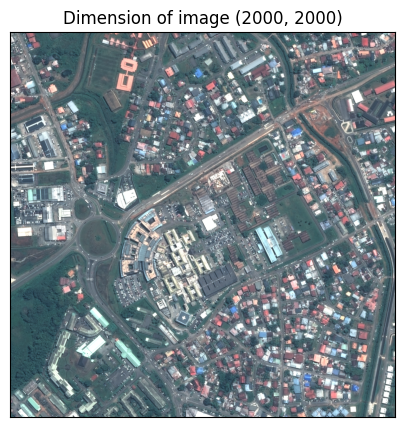

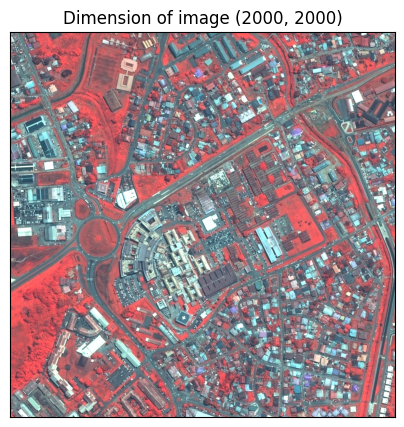

In [39]:
image.plot([0,1,2])
image.plot([3,1,2])

On choisit ce seuil en testant plusieurs quantiles et en regardant le meilleur résultat

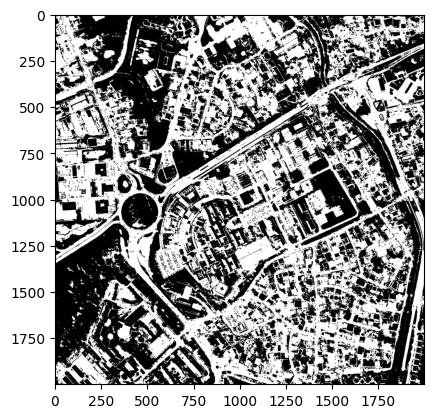

In [45]:
#on extrait l'array de l'image pour avoir les valeurs des pixels
img = image.array.copy()

img = img.transpose(2,1,0)
shape = img.shape

seuil = np.quantile(img[:,:,3],0.5)
black = np.ones(shape, dtype = float)
white = np.zeros(shape, dtype = float)
mask = np.where(img>seuil, white,black)
mask = mask.transpose(2,1,0)
mask = mask[3,:,:]

plt.imshow(mask, cmap='gray')
plt.show()

## Méthode 1 bis : seuillage local sur l'infrarouge avec une médiane différente pour chaque patch d'image.

In [84]:
list_images = image.split(250)
list_mask = []
list_bounding_box = np.array([im.bounds for im in list_images])
list_images = order_list_from_bb(list_bounding_box, list_images)
list_indice_mask = [i for i in range(64)]

# We go through each patch
for mini_image in list_images:
    # Extract the array from the image to get the pixel values        
    img = mini_image.array.copy()

    # Multiply by 255 and convert to uint8 to get the correct format
    img = img.astype(float)

    img = img.transpose(2,1,0)
    shape = img.shape
    # Threshold
    threshold = np.quantile(img[:,:,3],0.5)
    black = np.ones(shape, dtype = float)
    white = np.zeros(shape, dtype = float)

    # Creation of the mask : all the infrared prixels below the threshold will be black and all the infrared prixels above the threshold will be white.
    mask = np.where(img>threshold, white,black)

    # Return to the intial shape
    mask = mask.transpose(2,1,0)

    list_mask.append(mask)
    
n_col = len(np.unique(np.array([bb[0] for bb in list_bounding_box])))
n_row = len(np.unique(np.array([bb[3] for bb in list_bounding_box])))

mat_list_mask = np.transpose(np.array(list_indice_mask).reshape(n_row, n_col))

# Create the grid of pictures and fill it with masks
masks = np.empty((n_col, n_row), dtype=object)        

for i in range(n_col):
    for j in range(n_row):
        masks[i, j] = mat_list_mask[i, j].array

mask = np.array(list_mask)

# Create a figure and axes
fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(10, 10))

# Iterate over the grid of images and plot them
for i in range(n_row):
    for j in range(n_col):
        axs[i, j].imshow(
            np.transpose(masks[i, j], (1, 2, 0))[:, :, 3]
        )

# Remove any unused axes
for i in range(n_row):
    for j in range(n_col):
        axs[i, j].set_axis_off()

# Show the plot
plt.show()




AttributeError: module 'numpy' has no attribute 'darray'

In [62]:
mat_list_mask = np.transpose(np.stack(list_mask).reshape(n_row, n_col))

ValueError: cannot reshape array of size 16000000 into shape (8,8)

In [96]:
list_mask2 = [i for i in range(64)]

In [97]:
list_mask2

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]

In [93]:
np.ndarray(list_mask[:32])

TypeError: only integer scalar arrays can be converted to a scalar index

In [91]:
list_mask.reshape(8,8)

AttributeError: 'list' object has no attribute 'reshape'

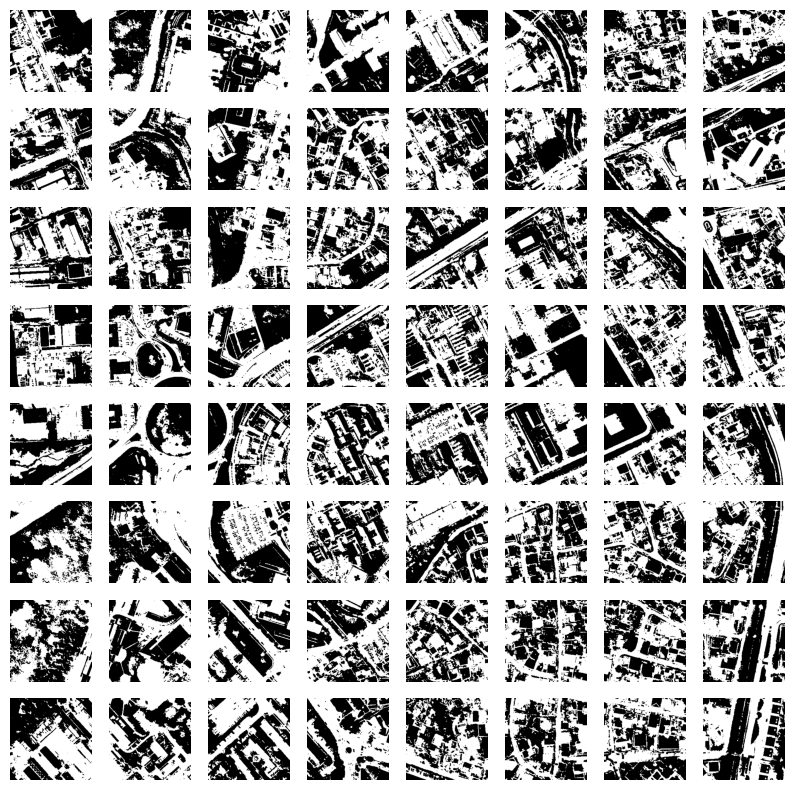

In [7]:
list_images = image.split(250)

#on parcourt chaque patch
for mini_image in list_images:
    #on extrait l'array de l'image pour avoir les valeurs des pixels
    img = mini_image.array

    #multiplication par 255 et convertion en uint8 pour avoir le bon format
    img = (img * 255).astype(np.uint8)

    img = img.transpose()
    
    seuil = np.quantile(img[:,:,3],0.5)
    
    #on parcours tous les pixels et on les modifie en fonction du seuil
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            i = img[row,col,3]
            if i > seuil: #médiane
                img[row, col] = np.array([0, 0, 0,0]) # blanc

            else : 
                img[row, col] = np.array([255,255,255,255]) # noir
    
    img = img.transpose()

    #On veut le bon format
    img = (img/255).astype(np.float64)

    mini_image.array = img

plot_list_satellite_images(list_images,bands_indices = [0,1,2])



## Méthode 2 : transformation de l'image infrarouge en image RGB en remplacant le rouge par l'infrarouge puis seuillage sur les 3 couleurs.

In [19]:
#on recharge l'image originale
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )
image.normalize()

On va refaire le même algorithme, sauf qu'on va changer les seuils sur les pixels RGB à la place de seulement infrarouge comme précedemment.

In [20]:
img = image.array

img = (img * 255).astype(np.uint8)


img = img.transpose()

* Etape 1 : Pour que le pixel soit une nuance de rouge, il faut d'abord vérifier si les valeurs verte et bleue sont proches.
* Etape 2 : On décide que les nuances de rouge très claires correspondent à des toits de bâtiments.
* Etape 3 : On fixe le seuil de la valeur rouge à 110 et la valeur de rouge avec une autre couleur doit être supérieure à 20 minimum.
* Etape 4 : Si le pixel ne vérifie aucune des étapes précédentes, alors il est colorié automatiquement en blanc.

Pour fixer ce seuil, des tests visuels ont été effectués et on a utilisé ce site https://htmlcolorcodes.com/fr/selecteur-de-couleur/ pour comprendre comment fonctionnent les nuances de rouge sur des pixels en décimal (et ce site pour comprendre les pixels en décimal en général http://www.proftnj.com/RGB3.htm).
L'algorithme qui suit met quelques secondes à tourner, il sera long s'il est appliqué sur l'ensemble des images de la base de données.
Pour mieux réussir à faire ce seuillage en étape 3, on devrait créer une fonction racine carré et prendre toutes les valeurs au dessus de la courbe.
Cette fonction est difficile à déterminer... Cependant, on peut la faire uniquement avec deux paramètres : la valeur du rouge et la valeur minimale entre le bleu et le vert. 

In [21]:
# On va parcourir tous les pixels de l'image
for row in range(img.shape[0]):
    for col in range(img.shape[1]):
        b = img[row,col, 1]
        g = img[row,col, 2]
        r = img[row,col, 3]
        mini = min(b,g)
        maxi = max(b,g)
        
        if maxi-mini <= 20 : #étape 1
            
            if r > 200 and mini >= 110 and r>= (20+mini): #étape 2
                img[row, col] = [255,255,255,255] # blanc
            elif  r>= (20+mini) and r >= 110: #étape 3
                img[row, col] = [0,0,0,0] #noir
            else : #étape 4
                img[row, col] = [255,255,255,255] # blanc

        else : #étape 4
            img[row, col] = [255,255,255,255] # blanc

In [22]:
img = img.transpose()

#On veut le bon format
img = (img/255).astype(np.float64)

image.array = img

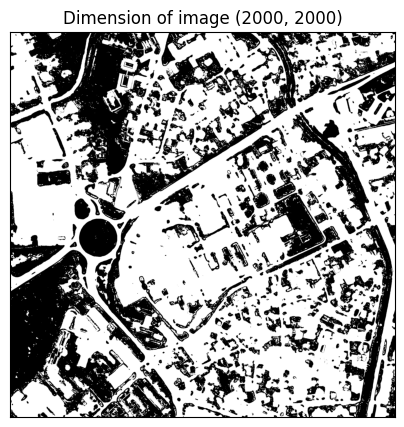

In [23]:
image.plot([0,1,2])

Ici, la 2ème méthode est plus effective. En effet, on prend en compte que certains toits vont refleter les ondes infrarouges et donc sortir comme rouge clair une fois l'image convertie en RGB. Cependant, la méthode du seuillage sur l'infrarouge reste la plus simple : méthode concise et temps de calcul plus rapide. Les résultats semblent globalement bon dans les deux cas. A voir quelle méthode se généralise le mieux...

## Essai au cas où : Détection de contours

In [57]:
#On récupère l'image au format RGB puis on la transforme en png pour pouvoir l'utiliser avec OpenCV
img = image.array

img = img[[0,1,2],:, :]

img = (img*255).astype(np.uint8)

#convertir l'array en image PIL pour ensuite l'avoir en png
img = im.fromarray(img.transpose(1, 2, 0).astype('uint8'), 'RGB')

#enregistrer l'image en tant que fichier PNG pour pouvoir utiliser OpenCV
img.save('masque.png')

Afin de ne pas faire crasher le kernel, nous allons préalablement créer des fonctions d'affichage des images avec OpenCV (la fonction de base cv2.imshow() fait crasher le kernel)

In [58]:
#images en nuances de gris
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "gray")

#images en couleurs
def cv2_imshow2(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "brg")

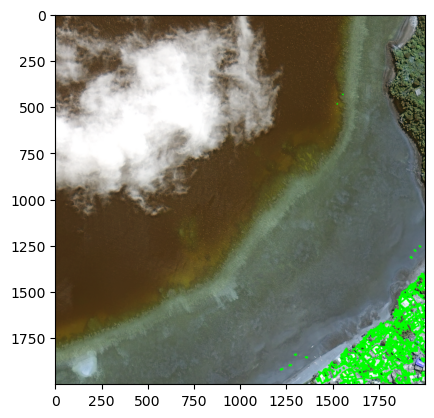

In [63]:
#on lit l'image avec OpenCV
img = cv2.imread('masque.png')

#avoir le bon format : ici on veut RGB (la transposée nous a fait passer en BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Find Canny edges
edged = cv2.Canny(gray, 100, 1000)
  
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
img_contours = cv2.drawContours(img, contours, -1, (0, 255, 0), 5)
cv2_imshow2(img_contours)

Ce qui serait intéressant de faire, c'est de prendre en entrée des images où on sait qu'il y a des bidonvilles, on enlève la végétation avec la méthode 2 mais on garde les couleurs de base sur les pixels sans végétation et ensuite on classifie ces pixels avec un algo des k-means. Comme ça, on peut faire plusieurs classes d'objets : routes, gros bâtiments, maisons, bidonvilles. On determine à la main quelle classe correspond à quel type d'objets. Puis on fait un masque binaire : en blanc les pixels dans la classe bidonville, en noir le reste. Cela pourrait nous aider à constituer des données d'apprentissage.

## Maintenant, il serait intéressant de comparer deux images d'un même lieu sur deux périodes données où on sait qu'il y a eu une création/destruction de bâtiment entre temps.

## Idée globale : 
Trouver un lieu où il y a eu une construction/destruction de bâtiments entre deux millésimes et appliquer la méthode pour obtenir un masque sur les deux images infrarouge du même lieu à deux période données. Ensuite superposer ces deux masques et faire des différences de pixels : les différences sortiront en blanc et les similarités en noir. Pour finir, on veut lisser l'image, c'est à dire trouver un seuil à partir duquel on considère qu l'amas de pixels représente un changement significatif. 

La première difficulté ici est de trouver deux images différentes d'un même lieu. On va parcourir les données pour savoir si c'est possible ou si c'est irréalisable sans faire de transformation.

In [10]:
#image 1
filename_1 = '../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0697_1640_U20N_8Bits.jp2'
date_1 = date.fromisoformat('2022-01-01')

In [11]:
image_1 = SatelliteImage.from_raster(
        filename_1,
        date = date_1, 
        n_bands = 3,
        dep = "972"
    )
image_1.normalize()

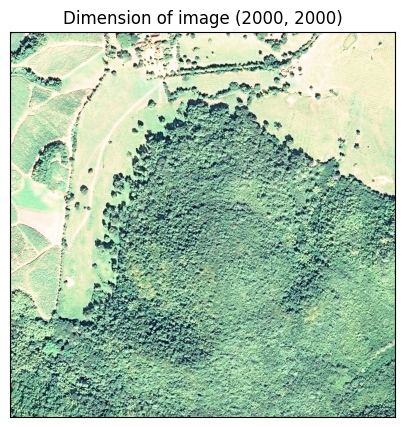

In [ ]:
image_1.plot([0,1,2])

Avant tout, on peut noter que le nom du fichier contient les coordonnées left-top du boundingbox de l'image, donc on est pas olbigés d'ouvrir l'image pour savoir quelles sont ses coordonnées. En effet, pour retrouver les coordonnées du carré de la bounding box, il faut rajouter 1000.0 à left pour obtenir right et enlever 1000.0 à top pour obtenir bottom.

On créé des fonctions crs_to_gps() et gps_to_crs() pour retrouver l'image sur google maps grâce à ses coordonnées crs transformées en gps et inversement, pour retrouver un point gps repéré sur Google Maps et le situer sur les images de la base de données grâce à ses données crs.

In [17]:
def crs_to_gps_image(satellite_image = None, filepath = None) :
    
    if satellite_image != None:
        folder_path = '../data/PLEIADES/' + str((satellite_image.date).year) + '/' + mapps.num_dep_to_name_dep[satellite_image.dep]
        filepath = folder_path + '/' + satellite_image.filename

    delimiters = ["-", "_"]

    pattern = "|".join(delimiters)

    split_filepath = re.split(pattern, filepath)

    x = float(split_filepath[2])*1000 #left
    y = float(split_filepath[3])*1000 #top
    
    delimiters = ["/"]

    pattern = "|".join(delimiters)

    split_filepath = re.split(pattern, filepath)
    
    dep_num = mapps.name_dep_to_num_dep[split_filepath[4]]
    str_crs = mapps.dep_to_crs[dep_num]
    
    transformer = Transformer.from_crs(str_crs, 'EPSG:4326',always_xy=True) 
    lon, lat = transformer.transform(x,y)
    
    # Retourner les coordonnées GPS (latitude, longitude)
    return lat, lon

In [18]:
crs_to_gps_image(image_1) #test

(14.827025734562506, -61.16930531772711)

In [19]:
crs_to_gps_image(None, filename_1)

(14.827025734562506, -61.16930531772711)

In [13]:
from pyproj import Transformer

In [196]:
def gps_to_crs_point(lat,lon,crs) :
    # Convertir les coordonnées GPS en coordonnées dans le système de coordonnées de destination (CRS)
    transformer = pyproj.Transformer.from_crs('EPSG:4326','EPSG:'+str(crs),always_xy=True) #au cas où le CRS en entrée est de type entier 
    x, y = transformer.transform(lon, lat) #car y=lat et x=lon, les coordonnées gps sont en (lat,lon)
    
    # Retourner les coordonnées dans le CRS spécifié
    return x, y


In [191]:
gps_to_crs_point(14.636195717948983, -61.04095442371388, '5490') #test (on devrait avoir 697000 et 1640000...)

(711000.0000002225, 1618999.9999483444)

* (14.623226, -61.067901) correspond à des coordonnées gps du quartier de Trénelle Citron à Fort de France avec des habitations de fortune (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiS_Y3mvYT-AhXKyKQKHf5KBVoQFnoECAwQAQ&url=https%3A%2F%2Fwww.lemonde.fr%2Fpolitique%2Farticle%2F2009%2F10%2F15%2Fle-quartier-de-trenelle-a-fort-de-france-illustre-le-delabrement-de-l-habitat-en-outre-mer_1254357_823448.html&usg=AOvVaw2v1Gc_-kLh-CMDzK5ctPb-).
* (14.635338, -61.038345) plateau médico-technique construit en 2018 (côté droit du triangle). 
Essayons de retrouver l'image qui le contient.

In [21]:
def find_image_of_point(coordinate : list, folder_path, coord_gps = False) :
    
    if coord_gps == True :  
        #récupérer le crs via le département
        delimiter = ["/"]

        pattern = "|".join(delimiter)

        split_folder = re.split(pattern, folder_path)

        departement = split_folder[4]
        dep_num = mapps.name_dep_to_num_dep[departement]
        crs = mapps.dep_to_crs[dep_num]
        
        lat, lon = coordinate
        x,y = gps_to_crs_point(lat,lon,crs) 
    else :
        x,y = coordinate
        
    #récupérer les coordonnées left-top
    delimiters = ["-", "_"]

    pattern = "|".join(delimiters)
        
    for filename in os.listdir(folder_path):

        split_filename = re.split(pattern, filename)

        left = float(split_filename[2])*1000
        top = float(split_filename[3])*1000
        right = left + 1000.0
        bottom = top - 1000.0

        if left <= x <= right:
            if bottom <= y <= top:
                return(folder_path + '/' +filename)
    else : 
        return("Le point n'est pas retrouvé dans ce fichier d'images")


Vérifions la fonction avec les coordonnées left-top de l'image 1

In [22]:
find_image_of_point([713000.0, 1606000.0], '../data/PLEIADES/2022/MARTINIQUE') 

'../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0713_1607_U20N_8Bits.jp2'

Image des coordonnées recherchées

In [195]:
find_image_of_point([14.635338, -61.038345], '../data/PLEIADES/2022/MARTINIQUE', coord_gps = True)

'../data/PLEIADES/2022/MARTINIQUE/ORT_2022_0711_1619_U20N_8Bits.jp2'

In [230]:
def find_image_different_years(different_year : int, satellite_image = None, filepath : str = None) :
    
    if satellite_image != None:
        folder_path = '../data/PLEIADES/' + str((satellite_image.date).year) + '/' + mapps.num_dep_to_name_dep[satellite_image.dep]
        filepath = folder_path + '/'+ satellite_image.filename
    
    #récupérer le département de base
    delimiter = ["/"]

    pattern = "|".join(delimiter)

    split_folder = re.split(pattern, filepath)

    departement_base = split_folder[4]
    dep_num_base = mapps.name_dep_to_num_dep[departement_base]
    
    folder_path = '../data/PLEIADES/'+str(different_year)+'/'+departement_base
    
    #récupérer les coordonnées left-top
    if filepath.find('_') != -1 :
        delimiter = ["_"]
        
    elif filepath.find('-') != -1 :
        delimiter = ["-"]
        
    pattern = "|".join(delimiter)
        
    split_filepath = re.split(pattern, filepath)
        
    filename = os.listdir(folder_path)[0]
    
    if filename.find('_') != -1 :
        delimiter = ["_"]
        
    elif filename.find('-') != -1 :
        delimiter = ["-"]    
        
    pattern = "|".join(delimiter)
    
    split_filename = re.split(pattern, filename)

    split_filename[2] = split_filepath[2]
    split_filename[3] = split_filepath[3]
    
    return(folder_path+ '/' +delimiter[0].join(split_filename))


## Fonction d'affichage de plusieurs images

Choisir une image et faire un plot avec les x images qui l'entourent à une distance d. Par exemple, si on a une image et qu'on choisit d'afficher toutes les images qui l'entourent d'une distance 1, on va avoir un carré 3x3 avec l'image au centre. Distance 2 : carré 5x5 etc...

In [9]:
def plot_square_images(bands_indices: list, distance = 1, satellite_image = None, filepath_center_image = None):
    
    #récupérer le path du dossier
    delimiter = ["/"]

    pattern = "|".join(delimiter)

    split_filepath_center = re.split(pattern, filepath_center_image)

    folder_path = "/".join(split_filepath_center[0:5])
    
    if satellite_image != None:
        folder_path = '../data/PLEIADES/' + str((satellite_image.date).year) + '/' + num_dep_to_name_dep[satellite_image.dep]
        filepath_center_image = folder_path + '/'+ satellite_image.filename
    
    else :
        
        #récupérer l'année et le département
        annee = split_filepath_center[3]
        departement = split_filepath_center[4]
        dep_num = name_dep_to_num_dep[departement]

        #récupérer les coordonnées left-top de l'image du centre
        delimiters = ["-", "_"]

        pattern = "|".join(delimiters)

        split_filepath_center = re.split(pattern, filepath_center_image)

        left_center = float(split_filepath_center[2])*1000
        top_center = float(split_filepath_center[3])*1000

        list_images = []
        list_images_path = []

        for filename in os.listdir(folder_path):

            #récupérer les coordonnées left-top de toutes les images
            split_filename = re.split(pattern, filename)

            left = float(split_filename[2])*1000.0
            top = float(split_filename[3])*1000.0

            if left_center - distance*1000.0 <= left <= left_center + distance*1000.0:
                if top_center - distance*1000.0 <= top <= top_center + distance*1000.0:
                    image = SatelliteImage.from_raster(
                            folder_path + '/' +filename,
                            date = date.fromisoformat(annee + '-01-01'), 
                            n_bands = len(bands_indices),
                            dep = dep_num
                        )
                    image.normalize()
                    list_images.append(image)
                    list_images_path.append(image.filename)

    plot_list_satellite_images(list_images, bands_indices)